In [1]:
from __future__ import annotations
from datasets import load_dataset
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader
from tqdm import tqdm, trange
from collections import deque
from pathlib import Path
from model import UNet
from diffusion import GaussianDiffusionTrainer, GaussianDiffusionSampler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
net = torch.load("ckpts/cifat10_470000.pkt", weights_only = False).to(device)
net

UNet(
  (time_embedding): TimeEmbedding(
    (timembedding): Sequential(
      (0): Embedding(1000, 128)
      (1): Linear(in_features=128, out_features=512, bias=True)
      (2): Swish()
      (3): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (head): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downblocks): ModuleList(
    (0-1): 2 x ResBlock(
      (block1): Sequential(
        (0): GroupNorm(32, 128, eps=1e-05, affine=True)
        (1): Swish()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (temb_proj): Sequential(
        (0): Swish()
        (1): Linear(in_features=512, out_features=128, bias=True)
      )
      (block2): Sequential(
        (0): GroupNorm(32, 128, eps=1e-05, affine=True)
        (1): Swish()
        (2): Dropout(p=0.1, inplace=False)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (shortcut): Identity()
      (attn): Identity(

In [4]:
T = 1000
beta_1 = 1e-4
beta_T = 0.02
mean_type = "epsilon"
var_type = "fixedlarge"
img_size = 32

sampler = GaussianDiffusionSampler(
        net, beta_1, beta_T, T, img_size=img_size,
        mean_type=mean_type, var_type=var_type).to(device)

num_images = 6
batch_size = 6

net.eval()
with torch.no_grad():
    images = []
    desc = "generating images"
    for i in trange(0, num_images, batch_size, desc=desc):
        batch_size = min(batch_size, num_images - i)
        x_T = torch.randn((batch_size, 3, img_size, img_size))
        batch_images = sampler(x_T.to(device)).cpu()
        images.append((batch_images + 1) / 2)
    images = torch.cat(images, dim=0).numpy()

generating images: 100%|██████████| 1/1 [00:21<00:00, 21.66s/it]


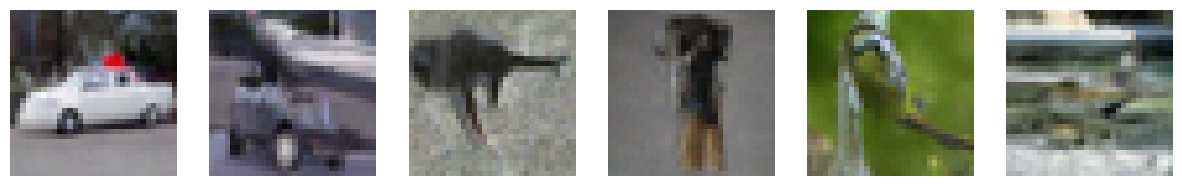

In [5]:
plt.figure(figsize=(15, 3))
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    # 转置通道顺序从[C,H,W]到[H,W,C]
    img = np.transpose(images[i], (1, 2, 0))
    plt.imshow(img)
    plt.axis('off')
plt.show()